<a href="https://colab.research.google.com/github/HBocaccio/NumLabIMC/blob/main/Colabs/nb04_Metodos2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introducción al modelado continuo** (*a.k.a.* **Ecuaciones de la física matemática**)
## Laboratorio numérico 2024

Bienvenidos al laboratorio numérico de la materia *Introducción al modelado continuo*, también conocida como *Ecuaciones de la física matemática*. En este, vamos a ver métodos numéricos para resolver distintos tipos de problemas de manera general, y su relación y aplicación a problemas específicos de la materia, de manera tal de complementar los contenidos de la cursada teórico-práctica.

# Motivación de este colab
<!-- $$\require{amsmath}$$ -->

Recordemos que estamos estudiando **sistemas dinámicos**, con reglas representadas por **ecuaciones diferenciales ordinarias (ODEs)**. En el caso 2D, vamos a tener conjuntos de pares de ecuaciones que describen la evolución temporal de dos variables.

Podemos ver directamente como encontrar **soluciones al problema de valor inicial en 2D** usando métodos de **integración numérica** 2D. Estas soluciones van a ser trayectorias en el diagrama de fases que nos permitirán estudiar el sistema. Inclusive, podemos ver la estrategia de **integrar hacia atrás**, para encontrar variedades inestables. También vamos a ver cómo **graficar el campo vector** usando herramientas de visualización de matplotlib. Por último, podemos complementar estos análisis con la **búsqueda de puntos fijos** y el estudio de su **estabilidad mediante linearización** del sistema.



# Métodos de integración numérica 2D

### [I. Método de Euler](#euler)
### [II. Método de Runge-Kutta](#rk4)
### [III. Método Odeint de scipy](#odeint)

<a name="euler"></a>
## I. Método de Euler 2D

Supongamos que tenemos una sistema de ecuación diferenciales del tipo:

$$\dot{x} = f(t, x, y)$$
$$\dot{y} = g(t, x, y)$$

Con una condición inicial dada $({x}_{0},{y}_{0})$.

Como vimos, la integración numérica consiste en aproximar las soluciones de un conjunto de ecuaciones diferenciales utilizando una discretización en la variable temporal. En el caso del método de Euler, vamos a aproximar mediante un mapa que va de $({x}_{n},{y}_{n})$ a $({x}_{n+1},{x}_{n+1})$.

Luego, un paso de integración mediante el método de Euler 2D será:

$${x}_{n+1} = {x}_{n} + h f(t_{n}, {x}_{n}, {y}_{n})$$
$${y}_{n+1} = {y}_{n} + h g(t_{n}, {x}_{n}, {y}_{n})$$

Esto también se puede expresar de manera vectorial, con posibilidad de generalizarse a más dimensiones

$${\vec{x}}_{n+1} = {\vec{x}}_{n} + h \vec{f}(t_{n}, {\vec{x}}_{n})$$

Que resuelve el sistema de ecuaciones general escrito de manera vectorial

$$\frac{d\vec{x}}{dt} = \vec{f}(t, \vec{x})$$



---

**Ejemplo:**

Por ejemplo, podemos replantear la función de integración de Euler realizada en la clase pasada, pero esta vez para el caso 2D. El objetivo será resolver el siguiente sistema de ecuaciones:

$$
\dot{x} = 4x+2y
$$
$$
\dot{y} = -17x-5y
$$

Igual que antes, hacemos Euler:
$$
x(t+dt) = x(t) + [4 x(t)+ 2 y(t)] dt
$$
$$
y(t+dt) = y(t) + [-17 x(t) - 5y(t) ]dt
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
# Definimos las ecuaciones que rigen el sistema
def ecuaciones(x, y, params=[]):
    x_dot = 4*x + 2*y
    y_dot = -17*x - 5*y
    return x_dot, y_dot

# Definimos la función para integrar con el método de Euler
def integrar_ecuaciones(total_time, dt, X0, params=[]):
    num_steps = int(np.divide(total_time, dt))
    xs = np.empty(num_steps)
    ys = np.empty(num_steps)
    xs[0], ys[0] = X0
    x_dot = np.empty(num_steps)
    y_dot = np.empty(num_steps)
    x_dot[0], y_dot[0] = ecuaciones(xs[0], ys[0], params)
    for i in range(num_steps-1):
        xs[i+1] = xs[i] + x_dot[i]*dt
        ys[i+1] = ys[i] + y_dot[i]*dt
        x_dot[i+1], y_dot[i+1] = ecuaciones(xs[i+1], ys[i+1], params)
    return xs, ys, num_steps

Integramos

In [3]:
# Definimos el paso de integración
dt = 0.05
# Definimos el tiempo total de integración
total_time = 20
# Definimos la condición inicial
X0 = (1.5, 0.0)
# Integramos
x, y, num_steps = integrar_ecuaciones(total_time, dt, X0)
# Definimos el vector de tiempos y los vectores x, y que iremos llenando
t = np.arange(0, total_time, step=dt)

Graficamos las soluciones. Vemos la evolución temporal de cada una de las variables y la trayectoria del flujo 2D en el espacio de fases.

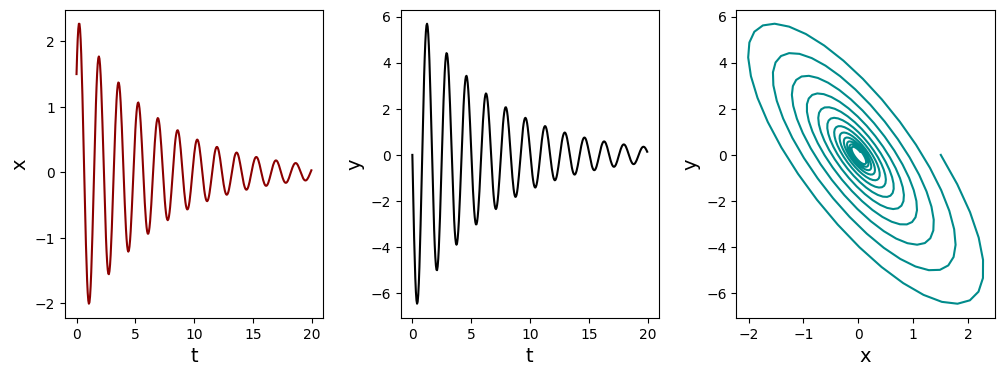

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(131)
plt.plot(t, x, 'darkred')
plt.xlabel('t', fontsize=14)
plt.ylabel('x', fontsize=14)

plt.subplot(132)
plt.plot(t, y, 'k')
plt.xlabel('t', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.subplot(133)
plt.plot(x, y, 'darkcyan')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.subplots_adjust(wspace=0.3)
plt.show()

**Pregunta:**

Qué tipo de punto es el origen?

---

<a name="rk4"></a>
## II. Método de [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)



La generalización de RK4 a ordenes superiores es directa, pero en lugar de considerar a las variables como escalares, ahora son vectores

$$\vec{K}_1 = \vec{f}(t_n, \vec{x}_n)\\
\vec{K}_2 = \vec{f}\left(t_n + \frac{h}{2}, \vec{x}_n + \frac{h}{2} \vec{K}_1\right)\\
\vec{K}_3 = \vec{f}\left(t_n + \frac{h}{2}, \vec{x}_n + \frac{h}{2} \vec{K}_2\right)\\
\vec{K}_4 = \vec{f}(t_n + h, \vec{x}_n + h \vec{K}_3)$$

La actualización de $\vec{x}$ se realiza mediante:

$$\vec{x}_{n+1} = \vec{x}_n + \frac{h}{6} (\vec{K}_1 + 2\vec{K}_2 + 2\vec{K}_3 + \vec{K}_4)$$

In [7]:
def rk4(dxdt, x, t, dt, *args, **kwargs):
    x = np.asarray(x)
    k1 = np.asarray(dxdt(x, t, *args, **kwargs))*dt
    k2 = np.asarray(dxdt(x + k1*0.5, t, *args, **kwargs))*dt
    k3 = np.asarray(dxdt(x + k2*0.5, t, *args, **kwargs))*dt
    k4 = np.asarray(dxdt(x + k3, t, *args, **kwargs))*dt
    return x + (k1 + 2*k2 + 2*k3 + k4)/6

La forma de utilizarlo sería:

`x[i+1], y[i+1] = rk4(campo_vector, [x[i], y[i]], tt, dt)`

Lo aplicamos al sistema de antes

$$
\dot{x} = 4x+2y
$$
$$
\dot{y} = -17x-5y
$$


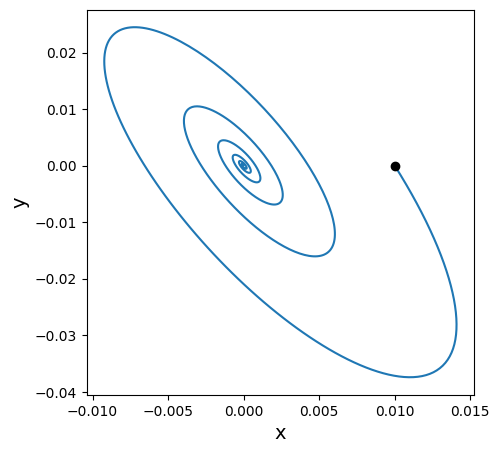

In [9]:
# # # Ahora vamos a definir una función "campo_vector" con el sistema de ecuaciones, en formato compatible con nuestra función rk4
def campo_vector(z, t):
    # Como ahora las variables vienen en una lista (en el primer argumento: z)
    # primero las separamos para que sea más claro
    x = z[0]
    y = z[1]
    # Y ahora calculamos las derivadas
    dxdt = 4*x + 2*y
    dydt = -17*x - 5*y
    return [dxdt, dydt]

# Integración Runge-Kutta 4
dt = 0.01
tmax = 10
t = np.arange(0, tmax, step=dt)
xrk = np.zeros_like(t)
yrk = np.zeros_like(t)
xrk[0] = 0.01
yrk[0] = 0
for ix, tt in enumerate(t[:-1]):
    xrk[ix+1], yrk[ix+1] = rk4(campo_vector, [xrk[ix], yrk[ix]], tt, dt)
plt.figure(figsize=(5,5))
plt.plot(xrk, yrk)
plt.plot(xrk[0], yrk[0], 'ko')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

Para varias condiciones iniciales

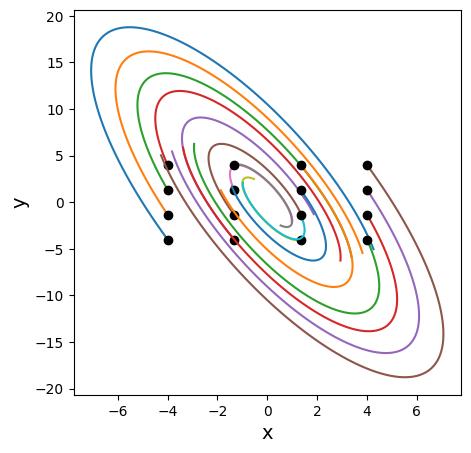

In [10]:
# Integración Runge-Kutta 4
dt = 0.01
tmax = 1
t = np.arange(0, tmax, step=dt)
plt.figure(figsize=(5,5))
Xi = np.linspace(-4, 4, 4)
Yi = np.linspace(-4, 4, 4)
for xi in Xi:
    for yi in Yi:
        xt = np.zeros_like(t)
        yt = np.zeros_like(t)
        xt[0], yt[0] = xi, yi
        # for ix, tt in enumerate(t[:-1]):
        #     xt[ix+1], yt[ix+1] = rk4(campo_vector, [xt[ix], yt[ix]], tt, dt)
        for i in range(len(t)-1):
            xt[i+1], yt[i+1] = rk4(campo_vector, [xt[i], yt[i]], t[i], dt)
        plt.plot(xt, yt)
        plt.plot(xt[0], yt[0], 'ko')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

---
## III. [Odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)

En 2 (o más) dimensiones funciona muy parecido al caso 1D. Sólo nos tenemos que ocupar de escribir correctamente el campo vector para que el primer argumento sea una lista que va a contener en cada elemento una variable distinta, desempaquetarlo y devolver un array de derivadas.

```
def campo_vector(variables, t):
    var1 = variables[0]
    var2 = variables[1]
    ...
    dvar1 = ...
    dvar2 = ...
    ...
    return [dvar1, dvar2, ...]
```

Veamoslo con el sistema de antes

$$
\dot{x} = 4x+2y\\
\dot{y} = -17x-5y
$$

Podemos aprovechar que ya escribimos la función `campo_vector` con el formato necesario, y utilizarla

[[ 1.00000000e-02  0.00000000e+00]
 [ 1.00399099e-02 -1.69914326e-04]
 [ 1.00796394e-02 -3.39656489e-04]
 ...
 [ 6.35455004e-06  1.82042740e-04]
 [ 6.74380586e-06  1.81023764e-04]
 [ 7.13257799e-06  1.80003275e-04]]


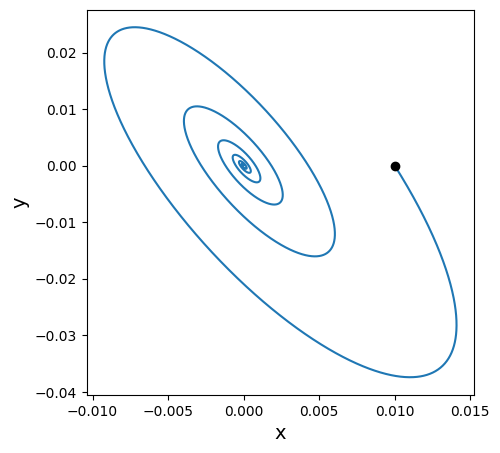

In [11]:
dt = 0.001
tmax = 10
t = np.arange(0, tmax, dt)
# Ponemos condiciones iniciales
xi = 0.01
yi = 0
# Y nos armamos una lista que contiene ci de cada variable
zi = [xi, yi]
# Llamamos al odeint y vean que le pasamos la lista de condiciones iniciales!
sol = sp.integrate.odeint(campo_vector, zi, t)
# Vean como nos viene la solución:
print(sol)
plt.figure(figsize=(5,5))
plt.plot(sol[:, 0], sol[:, 1])
plt.plot(xi, yi, 'ko')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

### Problemas con Odeint

Hay circunstancias donde el integrador odeint puede llegar a tener problemas y, al no tener acceso al algoritmo de manera transparente (recordemos que va cambiando de método segun le convenga), es difícil lidiar con ellos.

Veamos por ejemplo cómo se dibujan las soluciones del campo vector en este ejemplo:

/home/joacopolo/Documents/venvs/general-venv/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


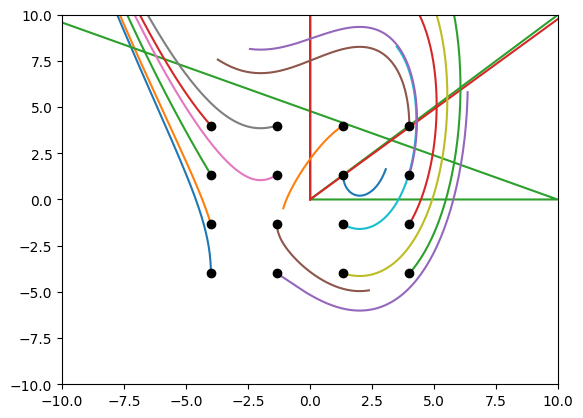

In [12]:
# Sistema de ecuaciones
# (notar que podriamos definir primero el tiempo como variable de entrada, usando el argumento tfirst del odeint)
def f(z, t): #f(t, z)
    x = z[0]
    y = z[1]
    dxdt = x-y
    dydt = x**2-4
    return [dxdt, dydt]

# Integración odeint
dt = 0.01
tmax = 1.3
t = np.arange(0, tmax, dt)
Xi = np.linspace(-4, 4, 4)
Yi = np.linspace(-4, 4, 4)
plt.figure()
for xi in Xi:
    for yi in Yi:
        zi = [xi, yi]
        sol_fut = sp.integrate.odeint(f, zi, t) #, tfirst=True
        xt = sol_fut[:, 0]
        yt = sol_fut[:, 1]
        plt.plot(xt, yt)
        plt.plot(xt[0], yt[0], 'ko')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

Esto era lo que daba con el integrador RK4 de antes

/tmp/ipykernel_4455/3589514498.py:7: RuntimeWarning: overflow encountered in scalar power
  dydt = x**2-4


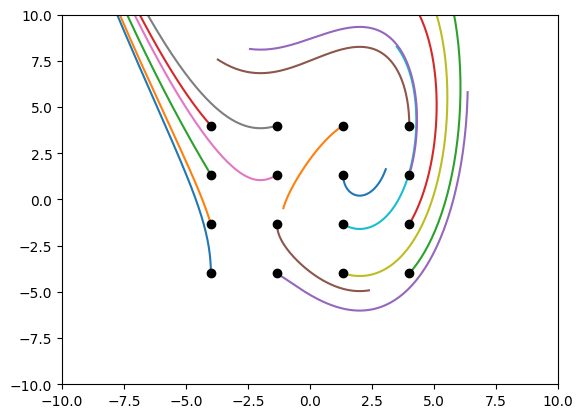

In [14]:
plt.figure()
for xi in Xi:
    for yi in Yi:
        xt = np.zeros_like(t)
        yt = np.zeros_like(t)
        xt[0], yt[0] = xi, yi
        for i in range(len(t)-1):
            xt[i+1], yt[i+1] = rk4(f, [xt[i], yt[i]], t[i], dt)
        plt.plot(xt, yt)
        plt.plot(xt[0], yt[0], 'ko')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

### Alternativas con Scipy

La función `sp.integrate.odeint` ya quedará en desuso de acerdo a la documentación de Scipy. Recomiendan el uso de la función `sp.integrate.solve_ivp` [(documentación)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

Probamos de aplicarlo al sistema de antes

$$
\dot{x} = 4x+2y
$$
$$
\dot{y} = -17x-5y
$$

Este sistema lo habíamos definido en la función `campo_vector(z, t)`. Ahora vamos a definir una nueva función `campo_vector_adaptado(t, z)` que tenga el tiempo como primera variable.

In [15]:
def campo_vector_adaptado(t, z):
    return campo_vector(z, t)

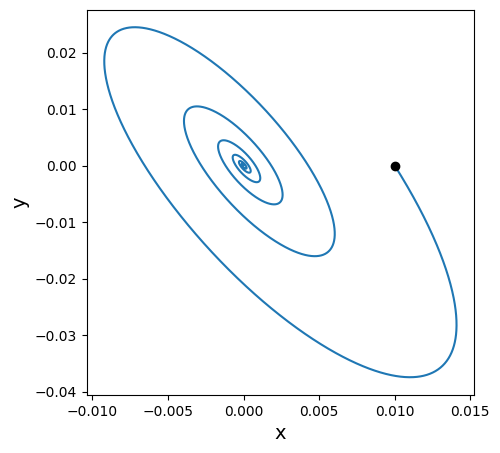

In [23]:
dt = 0.001
tmax = 10
t = np.arange(0, tmax, dt)
xi = 0.01
yi = 0
ti = t[0]
zi = [xi, yi]
sol = sp.integrate.solve_ivp(campo_vector_adaptado, [t[0], t[-1]], zi, t_eval=t, method='RK45')

plt.figure(figsize=(5,5))
plt.plot(sol.y[0, :], sol.y[1, :])
plt.plot(xi, yi, 'ko')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

---
## Ejercicio 1

1.1 Defina una función `fun()` que admita un parámetro de entrada `a`, para resolver el siguiente sistema general:

$$
\dot{x} = a.x+2y
$$
$$
\dot{y} = -17x-5y
$$

1.2. Muestre que se recupera la solución anterior para a=4.

1.3. Pruebe con un valor de a=7. ¿Cómo da la integración numérica para distintas condiciones iniciales? ¿Qué tipo de punto fijo es el orígen? Evalúe la solución para una condición inicial en ese punto (vea la solución sin necesariamente graficar).

1.4. ¿Y qué pasa para a=5? Pueder reptir esto para el integrador Odeint y comparar los resultados obtenidos.

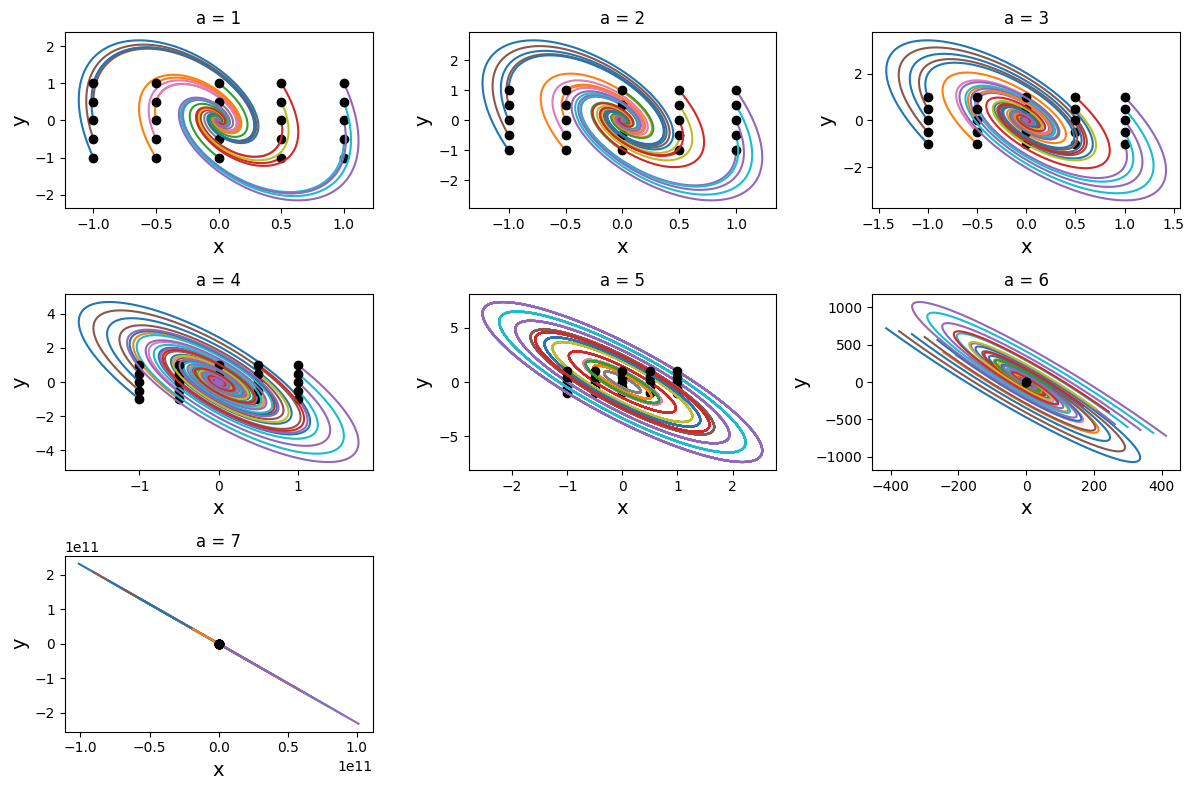

In [82]:
def fun(t, z, a=4):
    x = z[0]
    y = z[1]
    dxdt = a*x + 2*y
    dydt = -17*x - 5*y
    return dxdt, dydt

def generate_square_conditions(x_min, x_max, y_min, y_max, step=1):
    # Generate the grid of points for xi and yi
    x_values = np.arange(x_min, x_max + step, step)
    y_values = np.arange(y_min, y_max + step, step)

    # Create a meshgrid of points
    xi, yi = np.meshgrid(x_values, y_values)

    # Stack them as pairs of (xi, yi)
    initial_conditions = np.column_stack([xi.ravel(), yi.ravel()])
    
    return initial_conditions

DT = 0.001
TMAX = 10
plt.figure(figsize=(12,8))
for a in range(1, 8):
    t = np.arange(0, TMAX, DT)
    for [xi, yi] in generate_square_conditions(-1, 1, -1, 1, step=0.5):
        ti = t[0]
        zi = [xi, yi]
        sol = sp.integrate.solve_ivp(fun, [t[0], t[-1]], zi, t_eval=t, method='RK45', args=(a,))

        plt.subplot(3, 3, a)
        plt.title(f'a = {a}')
        plt.plot(sol.y[0, :], sol.y[1,  :])
        plt.plot(xi, yi, 'ko')
        plt.xlabel('x', fontsize=14)
        plt.ylabel('y', fontsize=14)
        
plt.tight_layout()
plt.show()

---
## Integrar hacia atrás

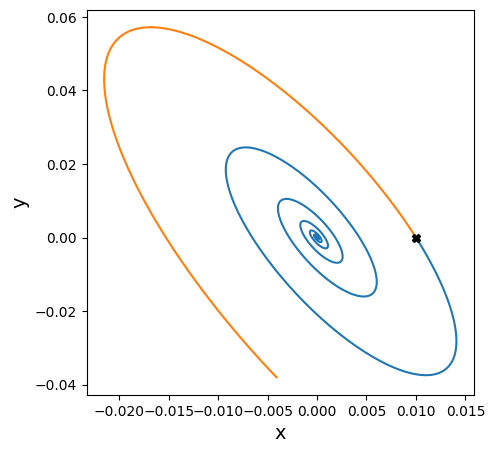

In [57]:
def campo_vector(z, t):
    x = z[0]
    y = z[1]
    dxdt = 4*x+2*y
    dydt = -17*x-5*y
    return [dxdt, dydt]

dt = 0.01
t = np.arange(0, 10, step=dt)
xrk = np.zeros_like(t)
yrk = np.zeros_like(t)
xrk[0] = 0.01
yrk[0] = 0
for ix, tt in enumerate(t[:-1]):
    xrk[ix+1], yrk[ix+1] = rk4(campo_vector, [xrk[ix], yrk[ix]], tt, dt)

tpas = np.arange(0, -1, step=-dt)
xrkpas = np.zeros_like(tpas)
yrkpas = np.zeros_like(tpas)
xrkpas[0] = 0.01
yrkpas[0] = 0
for ix, tt in enumerate(tpas[:-1]):
    xrkpas[ix+1], yrkpas[ix+1] = rk4(campo_vector, [xrkpas[ix], yrkpas[ix]], tt, -dt)

plt.figure(figsize=(5,5))
plt.plot(xrk, yrk)
plt.plot(xrkpas, yrkpas)
plt.plot(xrk[0], yrk[0], 'kX')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

De manera análoga, se puede adaptar la variable tiempo en la función `solve_ivp` para integrar hacia atrás.


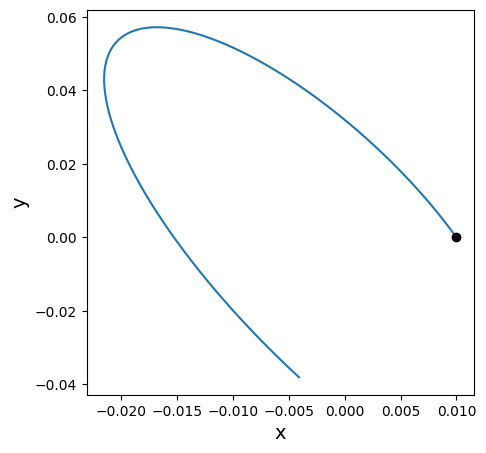

In [58]:
dt = 0.01
tmax = 1
t = np.arange(0, tmax, dt)
a = 4
xi = 0.01
yi = 0
zi = [xi, yi]
sol = sp.integrate.solve_ivp(fun, [t[-1], t[0]], zi, t_eval=t[::-1], method='RK45', args=(a,))

plt.figure(figsize=(5,5))
plt.plot(sol.y[0, :], sol.y[1, :])
plt.plot(xi, yi, 'ko')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

**Pregunta:**

Para qué piensan que puede servir integrar hacia atrás?

---

# Gráfico del campo vector

Primero armamos una grilla de puntos sobre los que calcularemos el campo vector. La grilla la armamos con [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html).

Para graficar las flechas una opción es usar [quiver](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.quiver.html) de matplotlib. Como siempre, pueden explorar qué parámetros tienen para personalizar y/o mejorar la visualización.

In [59]:
# Damos la grilla de puntos sobre la que miraremos el campo vector
x_grilla, y_grilla = np.meshgrid(np.linspace(-2, 2, 20),np.linspace(-6, 6, 24))
dx_grilla, dy_grilla = ecuaciones(x_grilla,y_grilla)
print(np.shape(dx_grilla)) # Para ver cuántas filas y columnas
print(dx_grilla[0][:]) # Miramos la primera fila, todas las columnas

(24, 20)
[-20.         -19.15789474 -18.31578947 -17.47368421 -16.63157895
 -15.78947368 -14.94736842 -14.10526316 -13.26315789 -12.42105263
 -11.57894737 -10.73684211  -9.89473684  -9.05263158  -8.21052632
  -7.36842105  -6.52631579  -5.68421053  -4.84210526  -4.        ]


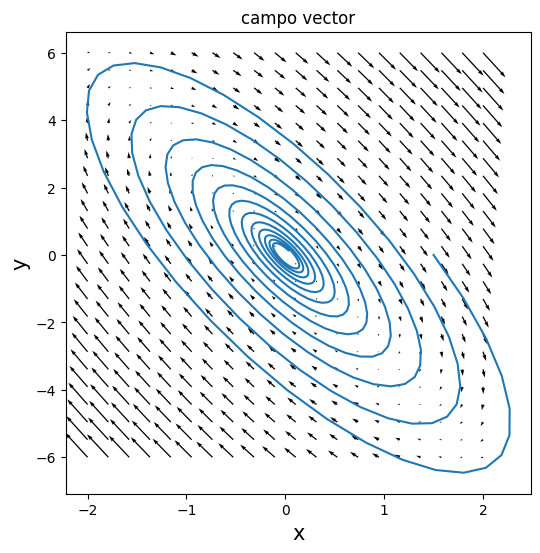

In [62]:
# Ahora las graficamos; usamos quiver de matplotlib -> chusmear la documentación
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title("campo vector")
ax.quiver(x_grilla, y_grilla, dx_grilla, dy_grilla, color='k', angles='xy')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.plot(x, y)
plt.show()

## Para visualizar el flujo rápido!
Una función **muy** útil para tener una buena idea de cómo es el flujo es [*streamplot*](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.streamplot.html#matplotlib.axes.Axes.streamplot). Lo que hace es integrar durante un tiempo corto en una grilla de puntos.

Para hacerlo andar, necesitamos calcular cuánto vale el campo vector en cada punto de la grilla. Primero nos definimos una grilla usando la función [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html).

In [63]:
# Definimos una grilla de puntos
XX, YY = np.meshgrid(np.arange(-2, 2, .01), np.arange(-4, 4, .01))

print(XX)
print(np.shape(XX))

[[-2.   -1.99 -1.98 ...  1.97  1.98  1.99]
 [-2.   -1.99 -1.98 ...  1.97  1.98  1.99]
 [-2.   -1.99 -1.98 ...  1.97  1.98  1.99]
 ...
 [-2.   -1.99 -1.98 ...  1.97  1.98  1.99]
 [-2.   -1.99 -1.98 ...  1.97  1.98  1.99]
 [-2.   -1.99 -1.98 ...  1.97  1.98  1.99]]
(800, 400)


Ahora podemos usar el campo vector para calcular las derivadas en cada uno de estos puntos. La sintaxis para hacer esto (y que los argumentos sean potables para el streamplot) es la siguiente:

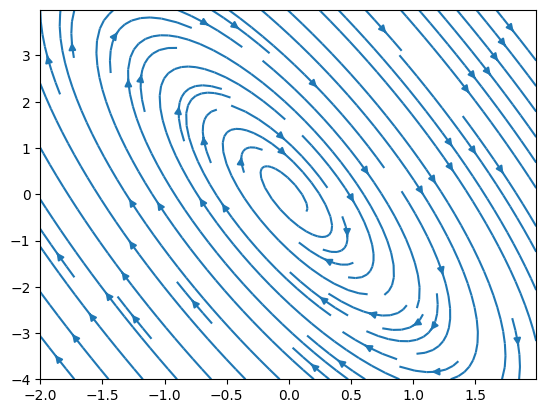

In [65]:
# Calculamos el campo vector en cada punto
DX, DY = campo_vector([XX, YY], 0)

#Y finalmente graficamos
plt.streamplot(XX, YY, DX, DY, density=1, minlength=.1)
# plt.streamplot(XX, YY, DX, DY, density=.51, minlength=.5)

## Para cambiar valores de parámetros del sistema interactivamente

Volvemos a ver el sistema del ejercicio 1

$$
\dot{x} = a.x+2y
$$
$$
\dot{y} = -17x-5y
$$

Podemos hacer un grafico que nos permita modificar el valor de $a$ de manera interactiva, y que use ese valor para definir el flujo del campo vector. Esto puede ser una herramienta simpática, aunque no siempre se de las más útiles.

In [66]:
from IPython.display import HTML
from ipywidgets import interact

In [67]:
def fun(t, z, a):
    x = z[0]
    y = z[1]
    dxdt = a*x + 2*y
    dydt = -17*x - 5*y
    return [dxdt, dydt]

In [68]:
a = 4
XX, YY = np.meshgrid(np.linspace(-4., 4., 100), np.linspace(-4.,4., 100))
def interactivo(a):
    DX, DY = fun(0, [XX, YY], a)
    fig = plt.figure(figsize=(5,5))
    plt.streamplot(XX, YY, DX, DY, density=1, arrowsize=1)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.show()

In [70]:
interact(interactivo, a=(0,15,1))

interactive(children=(IntSlider(value=7, description='a', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.interactivo(a)>

---
# Ejercicio 2

Se el sistema descrito por el siguiente conjunto de ecuaciones

$$
\dot{x} = y\\
\dot{y} = -x
$$

Encuentre la solución para condiciones iniciales [1, 0]. Puedo decir que se trata de un ciclo límite? Justifique usando las herramientas vistas



Text(0, 0.5, 'y')

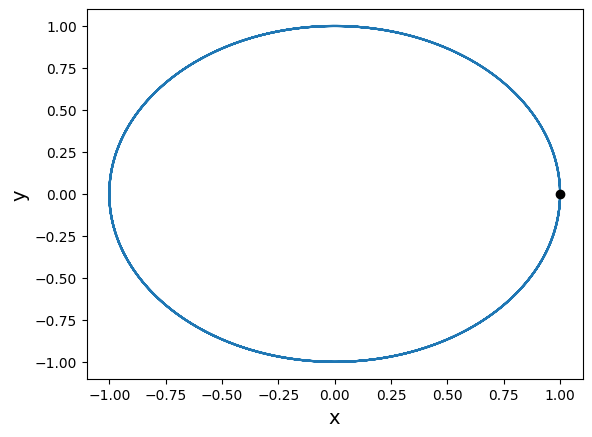

In [78]:
# # # COMPLETAR
def f_2(t, z):
    x = z[0]
    y = z[1]
    dxdt = y
    dydt = -x
    return [dxdt, dydt]

DT = 0.001
TMAX = 30
t = np.arange(0, TMAX, DT)

ti = t[0]
xi = 1
yi = 0
zi = [xi, yi]

sol = sp.integrate.solve_ivp(f_2, [t[0], t[-1]], zi, t_eval=t, method='RK45')

plt.plot(sol.y[0, :], sol.y[1,  :])
plt.plot(xi, yi, 'ko')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

---
# Ejercicio 3

La ecuación del [oscilador de Van der Pol](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator) está dada por

$$
\ddot{x} - \mu(1 - x^2)\dot{x} + x = 0
$$

3.1. Escriba una función llamada `van_der_pol` para esta ecuación expresada como un sistema dinámico.

3.2. Integre con `solve_ivp` para $\mu=2$ con condiciones iniciales $x=1$ y $\dot{x}=0$, dandole suficiente tiempo a la solución según considere.

3.3. Grafique el diagrama de fases ($x$, $\dot{x}$) de la solución con puntos en lugar de con líneas sólidas (incluya el punto de la condición inicial de manera distintiva). Qué puede observar en referencia a la distancia entre puntos? A qué se lo atribuye?


/tmp/ipykernel_4455/1250464204.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_sol, y_sol, cmap='viridis')


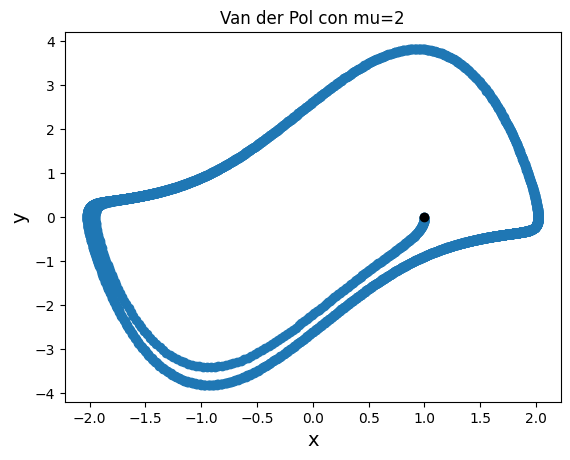

In [99]:
# # # COMPLETAR
def van_der_pol(t, z, mu=1):
    x = z[0]
    y = z[1]
    dxdt = y
    dydt = mu*(1-x**2)*y - x
    return [dxdt, dydt]

MU = 2
DT = 0.01c=t_sol, 
TMAX = 30
t = np.arange(0, TMAX, DT)

ti = t[0]
xi = 1
yi = 0
zi = [xi, yi]

sol = sp.integrate.solve_ivp(van_der_pol, [t[0], t[-1]], zi, t_eval=t, method='RK45', args=(MU,))
t_sol = sol.t
x_sol = sol.y[0, :]
y_sol = sol.y[1, :]

plt.title(f"Van der Pol con mu={MU}")
plt.scatter(x_sol, y_sol, cmap='viridis')
plt.plot(xi, yi, 'ko')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

/tmp/ipykernel_4455/3366237744.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(t_sol, x_sol, cmap='viridis')


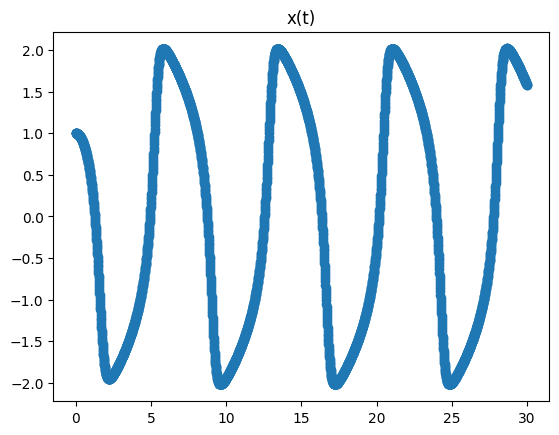

In [103]:
plt.scatter(t_sol, x_sol, cmap='viridis')
plt.title('x(t)')
plt.show()

---
# Ejercicio 4

Sea el siguiente sistema visto en clase

$$
\dot{\rho} = \rho(1-\rho)\\
\dot{\phi} = \omega + sin(\phi)
$$

4.1. Integre el sistema para w=1 usando distintas condiciones iniciales con $\rho$ entre 0 y 2, y $\phi_{inicial}=0$. Vea la evolución temporal de $\rho$.

4.2. Integre el sistema para w igual a -1, 0, y 1 usando como condiciones iniciales $\rho_{inicial}=1$ y $\phi_{inicial}=0$. Vea la evolución temporal de $\phi$. Cómo interpreta lo que está pasando?

4.3. Integre el sistema para w=1, usando como condiciones iniciales $\rho_{inicial}=1$ y $\phi_{inicial}=0$. Haga la transformación a coordenadas cartesianas usando las expresiones

$$
x = \rho.cos(\phi)\\
y = \rho.sin(\phi)
$$

Grafique en el diagrama de fases ($x$, $y$), pero usando puntos en lugar de una línea sólida. Qué observa? Estudie el flujo del campo vector para entender mejor lo que está pasando.

Para eso, genere una grilla en ($x$,$y$). Transformela a coordenadas polares usando la expresión

$$
\rho = \sqrt{x^2+y^2}\\
\phi = arctan \left(\frac{y}{x} \right)
$$

Calcule los valores del campo vector sin integrar en coordenadas polares y transforme esas velocidades a coordenadas cartesianas

$$
\dot{x} = \dot{\rho} \cos(\phi) - \rho \dot{\phi} \sin(\phi)\\
\dot{y} = \dot{\rho} \sin(\phi) + \rho \dot{\phi} \cos(\phi)
$$

Grafique usando `quiver`.


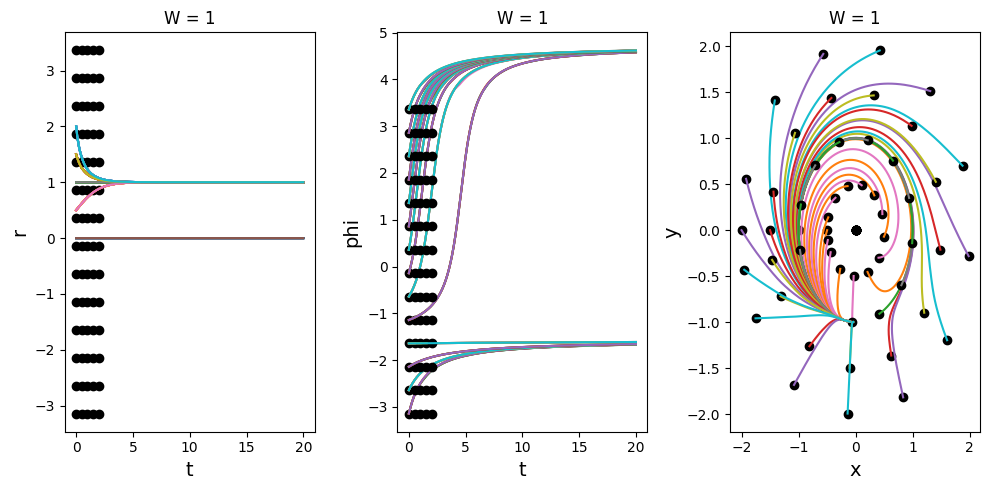

In [135]:
# # # COMPLETAR
def f_4(t, z, w=1):
    r = z[0]
    phi = z[1]
    
    drdt = r*(1-r)
    dphidt = w + np.sin(phi)
    
    return [drdt, dphidt]

condiciones_iniciales = generate_square_conditions(0, 2, -np.pi, np.pi, step=0.5)

DT = 0.01
TMAX = 20
t = np.arange(0, TMAX, DT)
W = 1
plt.figure(figsize=(10,5))
for [ri, phii] in condiciones_iniciales:
    ti = t[0]
    zi = [ri, phii]
    sol = sp.integrate.solve_ivp(f_4, [t[0], t[-1]], zi, t_eval=t, method='RK45', args=(W,))
    r_sol = sol.y[0, :]
    phi_sol = sol.y[1, :]
    t_sol = sol.t
    
    plt.subplot(1, 3, 1)
    plt.title(f'W = {W}')
    plt.plot(ri, phii, 'ko')
    plt.plot(t_sol, r_sol)
    plt.xlabel('t', fontsize=14)
    plt.ylabel('r', fontsize=14)
    
    plt.subplot(1, 3, 2)
    plt.title(f'W = {W}')
    plt.plot(ri, phii, 'ko')
    plt.plot(t_sol, phi_sol)
    plt.xlabel('t', fontsize=14)
    plt.ylabel('phi', fontsize=14)
    
    xi = ri * np.cos(phii)
    yi = ri * np.sin(phii)
    x_sol = r_sol*np.cos(phi_sol)
    y_sol = r_sol*np.sin(phi_sol)
    
    plt.subplot(1, 3, 3)
    plt.title(f'W = {W}')
    plt.plot(xi, yi, 'ko')
    plt.plot(x_sol, y_sol)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    
    
        
plt.tight_layout()
plt.show()

In [139]:
phi_sol[-1]-2*np.pi

-1.6649325674857138

In [127]:
phi_sol

array([0.        , 0.01005017, 0.02020133, ..., 4.69216991, 4.69217196,
       4.692174  ])

---
# [Extra] Nulclinas

Sea el sistema ya visto previamente en varias partes del Colab

$$
\dot{x} = 4x+2y
$$
$$
\dot{y} = -17x-5y
$$

Vamos a graficar las nulclinas

In [ ]:
def sistema_nulclinas(t, z):
    x = z[0]
    y = z[1]
    dxdt = 4*x + 2*y
    dydt = -17*x - 5*y
    return [dxdt, dydt]

Dos formas de calcular nulclina:
- cuando podemos despejar

In [ ]:
nuly_y = np.linspace(-2, 2)
nuly_x = -2/4*nuly_y
plt.plot(nuly_x, nuly_y)

nulx_x = np.linspace(-2, 2)
nulx_y = -17/5*nulx_x
plt.plot(nulx_x, nulx_y)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.show()

- más en general, usando `plt.contour` para levels=[0]



In [ ]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
XX, YY = np.meshgrid(x, y)
DX, DY = sistema_nulclinas(0, [XX, YY])

In [ ]:
c = plt.contour(XX, YY, DX, levels=[0], colors=['r'])
c = plt.contour(XX, YY, DY, levels=[0], colors=['g'])

Veamos el flujo de campo vector. Cómo espera que sea sobre las nulcinas?

In [ ]:
x_grilla, y_grilla = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
dx_grilla, dy_grilla = sistema_nulclinas(0, [x_grilla,y_grilla])
fig, ax = plt.subplots(figsize=(6,6))
ax.quiver(x_grilla, y_grilla, dx_grilla, dy_grilla, color='k', angles='xy')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
plt.show()

Qué espera que pase respecto a los puntos fijos?

---
# [Extra] Puntos fijos y estabilidad en 2D

Para el sistema anterior, vamos a calcular puntos fijos

In [ ]:
# Redefinimos el sistema sin la dependencia temporal
def sistema_nulclinas_sin_t(z):
    return sistema_nulclinas(0, z)

In [ ]:
N = 50
x0s = np.random.uniform(low=-2, high=2, size=(N,))
y0s = np.random.uniform(low=-2, high=2, size=(N,))
raices = []
for x0, y0 in zip(x0s, y0s):
    z0 = [x0, y0]
    raices.append(sp.optimize.fsolve(sistema_nulclinas_sin_t, z0))
raiz = np.unique(np.array(raices).round(2), axis=0)[0]

In [ ]:
raiz

El sistema de por sí es lineal, pero si tuviese que linearizar calcularía la matriz Jacobiana evaluada en el punto fijo. Después calculamos para esa matriz los autovalores y autovectores. En base a lo visto en el Colab, cómo espera que sean los autovalores?

In [ ]:
J = np.array([[4, 2],[-17, -5]])

# Calcular autovalores y autovectores
eigenvalues, eigenvectors = np.linalg.eig(J)

# Mostrar los resultados
print("Autovalores:")
print(eigenvalues)

print("\nAutovectores:")
print(eigenvectors)

La parte real negativa indica que el sistema es estable; las soluciones tienden a acercarse al punto fijo a medida que el tiempo avanza. La parte imaginaria sugiere que el sistema tiene un comportamiento oscilatorio alrededor del punto fijo. Esto implica que las soluciones no solo se acercan al punto fijo, sino que lo hacen en espiral. Por lo tanto, el punto fijo es un foco espiral estable. Las trayectorias en el espacio de fases girarán alrededor del punto fijo en espirales que decaen hacia el origen (el punto fijo).

Respecto a los autovectores, cuando tienen una parte imaginaria, como en este caso, la trayectoria no se dirige simplemente en una línea recta hacia el punto fijo, sino que gira a medida que se aproxima.

